In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Reading all the required files 
phenotype_gene_df=pd.read_csv("D:\\Saravanesh Personal\\Guvi\\Guvi_Career_Fair\\Gene_Causuality_Exploration\\11391053\\zenodo_directory\\zenodo_directory\data\\benchmark_datasets\\opentargets_step2.for_llm.tsv",sep='\t')
ground_truth_df=pd.read_csv('D:\\Saravanesh Personal\\Guvi\\Guvi_Career_Fair\\Gene_Causuality_Exploration\\11391053\\zenodo_directory\\zenodo_directory\data\\benchmark_datasets\\opentargets_step2.labels', sep='\t')
gene_embedding_df=pd.read_csv("D:\\Saravanesh Personal\\Guvi\\Guvi_Career_Fair\\Gene_Causuality_Exploration\\11391053\\zenodo_directory\\zenodo_directory\\data\\helper_datasets\\gene_embeddings.csv")
phenotype_embedding_df=pd.read_csv("D:\\Saravanesh Personal\\Guvi\\Guvi_Career_Fair\\Gene_Causuality_Exploration\\11391053\\zenodo_directory\\zenodo_directory\\data\\helper_datasets\\phenotype_embeddings.csv")

In [3]:
## Checking the dimensions of each dataframes 
print("The shape of the phenotype gene dataframe is :",phenotype_gene_df.shape)
print("The shape of ground truth dataframe is :",ground_truth_df.shape)
print("The shape of the gene embedding dataframe is :",gene_embedding_df.shape)
print("The shape of phenotype embedding dataframe is :",phenotype_embedding_df.shape)

The shape of the phenotype gene dataframe is : (851, 4)
The shape of ground truth dataframe is : (851, 2)
The shape of the gene embedding dataframe is : (10983, 4)
The shape of phenotype embedding dataframe is : (959, 4)


## Re-arranging and Re-Naming the column names in the dataframe for better understanding

In [4]:
gene_embedding_df.drop(columns='Unnamed: 0',axis=1,inplace=True)
gene_embedding_df.rename({'0':'symbol_gene_string','embedding':'gene_embedding'},axis=1,inplace=True)
phenotype_embedding_df.drop(columns='Unnamed: 0',inplace=True)
phenotype_embedding_df.rename({'0':'phenotype_description','embedding':'phenotype_embedding'},axis=1,inplace=True)

In [5]:
gene_embedding_df.head(5)

,symbol_gene_string,gpt_description,gene_embedding
0,ATMIN,"The ATMIN gene, also known as ATM interactor (...","[-0.01672099530696869, 0.025642508640885353, -..."
1,BCO1,"Gene BCO1, also known as beta-carotene oxygena...","[0.01961715891957283, -0.0013358700089156628, ..."
2,C16orf46,"Gene C16orf46, also known as Chromosome 16 Ope...","[-0.013213221915066242, 0.008565986528992653, ..."
3,CDYL2,"The gene CDYL2, also known as Chromodomain Y-l...","[-0.010155326686799526, 0.007696880027651787, ..."
4,CENPN,"The gene CENPN, also known as Centromere Prote...","[0.0019102469086647034, -0.01410931721329689, ..."


In [6]:
phenotype_embedding_df.head(5)

,phenotype_description,gpt_description,phenotype_embedding
0,Carotenoid and tocopherol levels (beta-caroten...,Carotenoids and tocopherols are important clas...,"[0.03543854132294655, -0.002083840314298868, -..."
1,Bilirubin levels,Bilirubin is a yellow pigment that is produced...,"[-0.002501995535567403, -0.03334518149495125, ..."
2,Sphingolipid levels (SM 14:0Mol%) (sphingomyel...,Sphingolipids are a class of lipids that play ...,"[-0.003154945094138384, -0.016002262011170387,..."
3,Fasting glucose-related traits (FPG) (D-Glucose),"Fasting glucose-related traits, also known as ...","[-0.026761554181575775, 0.011279185302555561, ..."
4,Vitamin D insufficiency (25-Hydroxyvitamin D2),"Vitamin D insufficiency, specifically referrin...","[0.004818837624043226, 0.01093713752925396, -0..."


## Creating hash value and seed value pertaining to the MD5 hash method

In [7]:
import hashlib

# Step 1: Hash your name to create a unique seed
name = "saravanesh"  # Replace with your name, all lowercase, no spaces
name_hash = hashlib.md5(name.encode()).hexdigest()  # Create an MD5 hash of the name
hash_seed = int(name_hash, 16) % (2**32)  # Convert hash to an integer within an acceptable range for a seed

# Display the hash value and the seed
print("Hash value:", name_hash)
print("Seed value:", hash_seed)


Hash value: 42b6ce0ae67bf5187b7252c0f2c7e169
Seed value: 4073185641


## Sampling the unique data for further processing

In [8]:
sample_phenotype_gene_df=phenotype_gene_df.sample(500,random_state=hash_seed)

In [9]:
sample_phenotype_gene_df.shape

(500, 4)

In [10]:
#Resetting the indexes
sample_phenotype_gene_df = sample_phenotype_gene_df.reset_index(drop=True)
ground_truth_df = ground_truth_df.reset_index(drop=True)

## Merging the Gene causal flag with the sample phenotype dataframe. 

In [11]:
# Extract the causal gene labels based on the 'row_number' from ground_truth_df
# Since ground_truth_df is ordered consistently with the original data, use 'row_number' to access the correct causal gene
sample_phenotype_gene_df['causal_gene'] = sample_phenotype_gene_df['row_number'].apply(lambda x: ground_truth_df.iloc[int(x) - 1, 0])


## There are duplicate records present in the dataframe pertaining to following features, removing them. 
- 'description', 'symbol_gene_string','ensembl_gene_string', 'causal_gene'

In [12]:
# Remove duplicates based on the relevant columns
sample_cleaned_df = sample_phenotype_gene_df.drop_duplicates(subset=['description', 'symbol_gene_string', 'ensembl_gene_string', 'causal_gene']).reset_index(drop=True)

# Display the cleaned dataframe to verify
print(f"Number of records before removing duplicates: {sample_phenotype_gene_df.shape[0]}")
print(f"Number of records after removing duplicates: {sample_cleaned_df.shape[0]}")

Number of records before removing duplicates: 500
Number of records after removing duplicates: 382


## Exploding the Genes in symbol_gene_string into rows. 

In [13]:
# Explode 'symbol_gene_string' and 'ensembl_gene_string' to create separate rows for each associated gene
sample_cleaned_df['symbol_gene_string'] = sample_cleaned_df['symbol_gene_string'].str.replace(r'[{}]', '', regex=True).str.split(',')
sample_cleaned_df['ensembl_gene_string'] = sample_cleaned_df['ensembl_gene_string'].str.replace(r'[{}]', '', regex=True).str.split(',')

# Create separate rows for each gene-phenotype combination using explode
exploded_df = sample_cleaned_df.explode(['symbol_gene_string', 'ensembl_gene_string']).reset_index(drop=True)

# Display the resulting dataframe to verify the explode operation
print(f"Number of records after exploding: {exploded_df.shape[0]}")

Number of records after exploding: 5849


In [14]:
exploded_df.head(5)

,row_number,description,symbol_gene_string,ensembl_gene_string,causal_gene
0,450,Psoriasis,EBF1,ENSG00000113302,IL12B
1,450,Psoriasis,IL12B,ENSG00000145860,IL12B
2,450,Psoriasis,RNF145,ENSG00000164330,IL12B
3,450,Psoriasis,UBLCP1,ENSG00000164332,IL12B
4,457,Worrier / anxious feelings (anxiety),GABRA1,ENSG00000022355,GABRA1


## Creating a new flag column to know whether a gene is causal or non-causal

In [15]:
# Create causal_gene_flag column: 1 if the gene is causal, 0 otherwise
exploded_df['causal_gene_flag'] = exploded_df.apply(lambda row: 1 if row['symbol_gene_string'] == row['causal_gene'] else 0, axis=1)

## Merging the exploded_df with genotype_df and phenotype_df

In [27]:
## Renaming the column
exploded_df.rename({'pheno_type_description':'phenotype_description'},axis=1,inplace=True)

In [29]:
final_df=exploded_df.merge(phenotype_embedding_df[['phenotype_description','phenotype_embedding']],
                           on='phenotype_description',how='left')

final_df=final_df.merge(gene_embedding_df[['symbol_gene_string','gene_embedding']],on='symbol_gene_string',how='left')

## After merging the dataset seems to be having some Nan values. 
## There are some phenotypes which does not have a corresponding embedding

In [30]:
print("No. of phenotypes without embedding :",len(final_df[final_df['phenotype_embedding'].isna()]['phenotype_description'].unique()))
print("Phenotype details : ",final_df[final_df['phenotype_embedding'].isna()]['phenotype_description'].unique())

No. of phenotypes without embedding : 18
Phenotype details :  ["Chronic inflammatory diseases (ankylosing spondylitis, Crohn's disease, psoriasis, primary sclerosing cholangitis, ulcerative colitis) [subset analysis]"
 'High cholesterol (Hypercholesterolemia)'
 'Heart attack vascular/heart problems diagnosed by doctor (myocardial infarction)'
 'Fasting Glucose (D-Glucose)' 'Polycythaemia vera (polycythemia vera)'
 'Deep venous thrombosis (dvt) (deep vein thrombosis)'
 'Metabolic syndrome [BP-HDLC]' 'Metabolic syndrome [HDLC-WC]'
 'Asthma or allergic disease' 'Metabolic syndrome [HDLC-GLUC]'
 'Advanced age-related macular degeneration (wet macular degeneration)'
 'Breast cancer illnesses of mother (breast carcinoma)'
 'Blood clot in the leg (dvt) (deep vein thrombosis)'
 'Pulmonary embolism +/- dvt' 'Advanced age-related macular degeneration'
 'Blood clot in the lung (pulmonary embolism)'
 'Chronic obstructive pulmonary disease or high blood pressure'
 'Fasting plasma glucose (D-Glucose

## Dropping the records that have missing values in phenotype_embeddings

In [31]:
final_cleaned_df=final_df.dropna().reset_index(drop=True)

In [32]:
final_cleaned_df.isna().sum()

row_number               0
phenotype_description    0
symbol_gene_string       0
ensembl_gene_string      0
causal_gene              0
causal_gene_flag         0
phenotype_embedding      0
gene_embedding           0
dtype: int64

## Converting the dtype of the embeddings

In [34]:
import numpy as np

# Function to convert embedding string to numpy array of floats
def convert_string_to_numpy(embedding_string):
    return np.fromstring(embedding_string.strip('[]'), sep=',')

# Apply conversion using numpy
final_cleaned_df['phenotype_embedding_new'] = final_cleaned_df['phenotype_embedding'].apply(convert_string_to_numpy)
final_cleaned_df['gene_embedding_new'] = final_cleaned_df['gene_embedding'].apply(convert_string_to_numpy)

# Verify the conversion
final_cleaned_df.head(5)


,row_number,phenotype_description,symbol_gene_string,ensembl_gene_string,causal_gene,causal_gene_flag,phenotype_embedding,gene_embedding,phenotype_embedding_new,gene_embedding_new
0,450,Psoriasis,EBF1,ENSG00000113302,IL12B,0,"[-0.002416918519884348, -0.006652179639786482,...","[0.028101174160838127, 0.0271750520914793, -0....","[-0.002416918519884348, -0.006652179639786482,...","[0.028101174160838127, 0.0271750520914793, -0...."
1,450,Psoriasis,IL12B,ENSG00000145860,IL12B,1,"[-0.002416918519884348, -0.006652179639786482,...","[0.016617292538285255, 0.005812177900224924, -...","[-0.002416918519884348, -0.006652179639786482,...","[0.016617292538285255, 0.005812177900224924, -..."
2,450,Psoriasis,RNF145,ENSG00000164330,IL12B,0,"[-0.002416918519884348, -0.006652179639786482,...","[-0.004920539446175098, 0.023182887583971024, ...","[-0.002416918519884348, -0.006652179639786482,...","[-0.004920539446175098, 0.023182887583971024, ..."
3,450,Psoriasis,UBLCP1,ENSG00000164332,IL12B,0,"[-0.002416918519884348, -0.006652179639786482,...","[0.009728760458528996, 0.004477985668927431, -...","[-0.002416918519884348, -0.006652179639786482,...","[0.009728760458528996, 0.004477985668927431, -..."
4,457,Worrier / anxious feelings (anxiety),GABRA1,ENSG00000022355,GABRA1,1,"[-0.02557842992246151, -0.0016910433769226074,...","[0.007830360904335976, 0.016814542934298515, 0...","[-0.02557842992246151, -0.0016910433769226074,...","[0.007830360904335976, 0.016814542934298515, 0..."


## Visualization of the data

C:\Users\sarav\AppData\Local\Temp\ipykernel_10200\1618794954.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='causal_gene_flag', data=final_cleaned_df, palette='viridis')


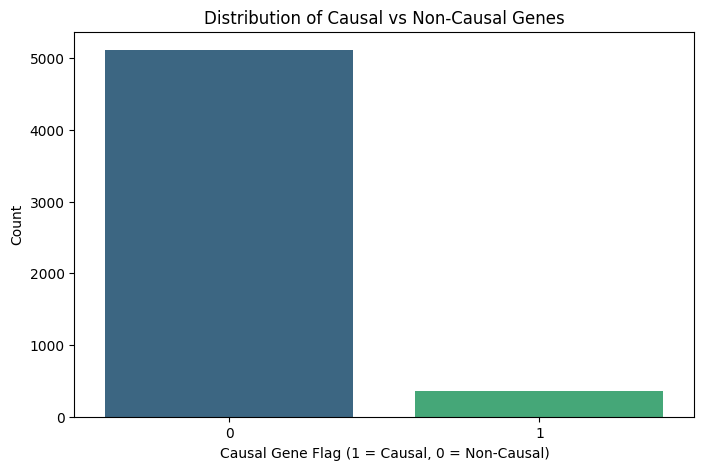

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of causal vs non-causal genes
plt.figure(figsize=(8, 5))
sns.countplot(x='causal_gene_flag', data=final_cleaned_df, palette='viridis')
plt.title('Distribution of Causal vs Non-Causal Genes')
plt.xlabel('Causal Gene Flag (1 = Causal, 0 = Non-Causal)')
plt.ylabel('Count')
plt.show()


### Segregating the embeddings in order to perform better visualizations

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'final_cleaned_df' is your dataframe, which now has numeric embeddings
# Let's first extract some dimensions from the embedding to visualize them
embedding_values = np.vstack(final_cleaned_df['gene_embedding_new'].values)
embedding_df = pd.DataFrame(embedding_values, columns=[f'emb_{i+1}' for i in range(embedding_values.shape[1])])
embedding_df['causal_gene_flag'] = final_cleaned_df['causal_gene_flag']

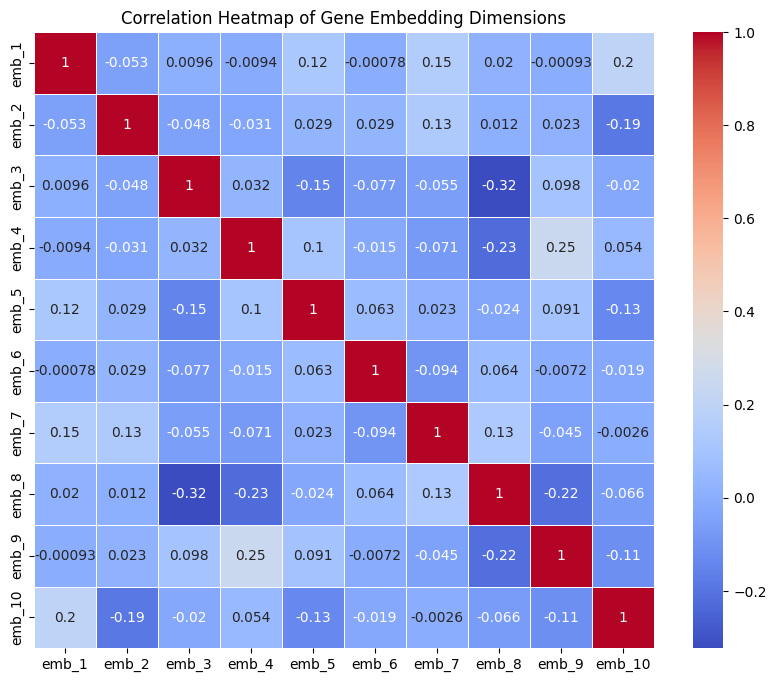

In [37]:
# Visualization 2: Correlation Heatmap for Embedding Dimensions
plt.figure(figsize=(10, 8))
corr_matrix = embedding_df.iloc[:, :10].corr()  # Considering the first 10 dimensions
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Gene Embedding Dimensions')
plt.show()

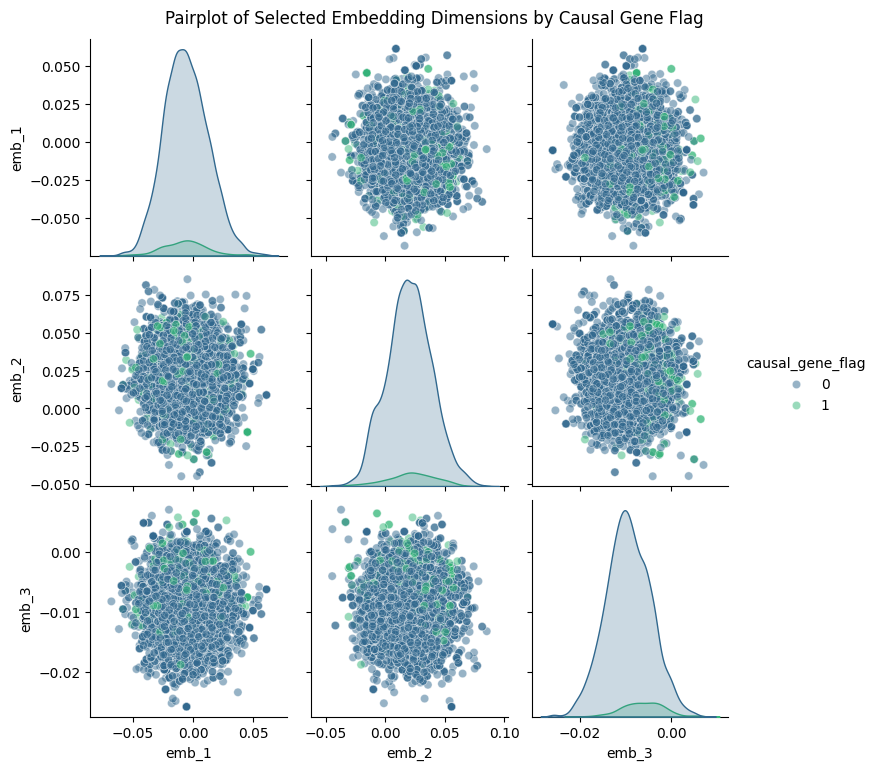

In [38]:
# Visualization 3: Pairplot of a Few Embedding Dimensions
sns.pairplot(embedding_df, vars=[f'emb_{i+1}' for i in range(3)], hue='causal_gene_flag', palette='viridis', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Selected Embedding Dimensions by Causal Gene Flag', y=1.02)
plt.show()

Brief Summary of Plots
1. Distribution of Causal vs Non-Causal Genes
The number of non-causal genes (0) is significantly higher than causal genes (1).
This indicates a class imbalance, which may impact the effectiveness of clustering and modeling.
2. Correlation Heatmap of Gene Embedding Dimensions
The correlations among the first 10 gene embedding dimensions are generally weak, suggesting minimal linear relationships between these features.
Most values are close to 0, indicating that the embeddings capture largely independent information for each dimension.
3. Pairplot of Selected Embedding Dimensions by Causal Gene Flag
The density and scatter plots show that there is no clear distinction between causal and non-causal genes in these selected embedding dimensions.
Causal genes (1, green) are mostly overlapping with non-causal genes (0, blue), showing minimal separation.

## Visualizing the Gene against the phenotype

In [39]:
# Assuming 'final_cleaned_df' is your dataframe, which now has numeric embeddings
# Extract gene embeddings and phenotype embeddings to visualize them
gene_embedding_values = np.vstack(final_cleaned_df['gene_embedding_new'].values)
phenotype_embedding_values = np.vstack(final_cleaned_df['phenotype_embedding_new'].values)

In [40]:
# Create separate dataframes for gene and phenotype embeddings
gene_embedding_df = pd.DataFrame(gene_embedding_values, columns=[f'gene_emb_{i+1}' for i in range(gene_embedding_values.shape[1])])
phenotype_embedding_df = pd.DataFrame(phenotype_embedding_values, columns=[f'phen_emb_{i+1}' for i in range(phenotype_embedding_values.shape[1])])


In [41]:
gene_embedding_df['causal_gene_flag'] = final_cleaned_df['causal_gene_flag']
phenotype_embedding_df['causal_gene_flag'] = final_cleaned_df['causal_gene_flag']

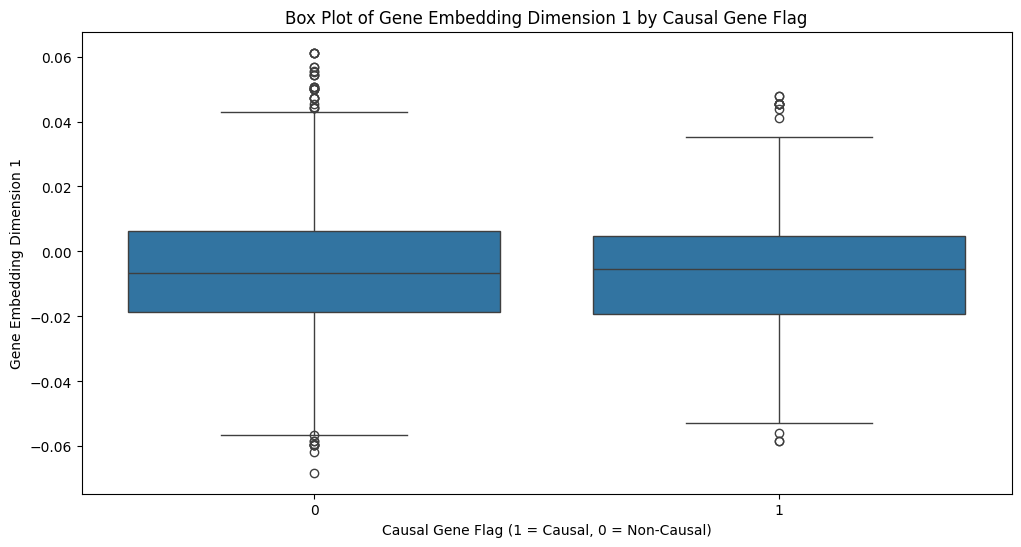

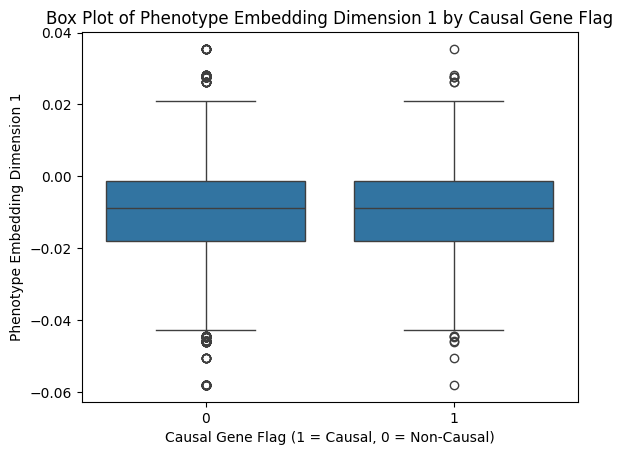

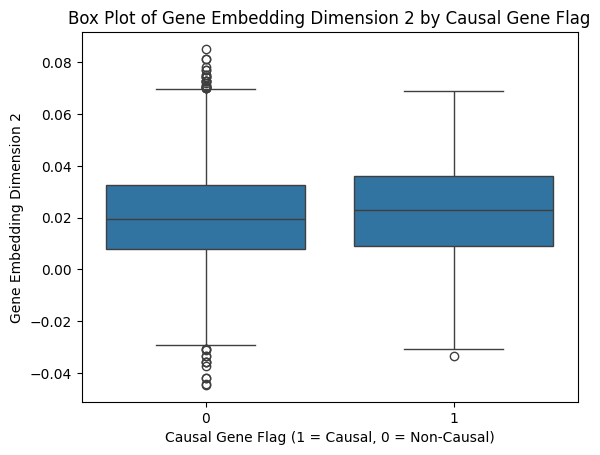

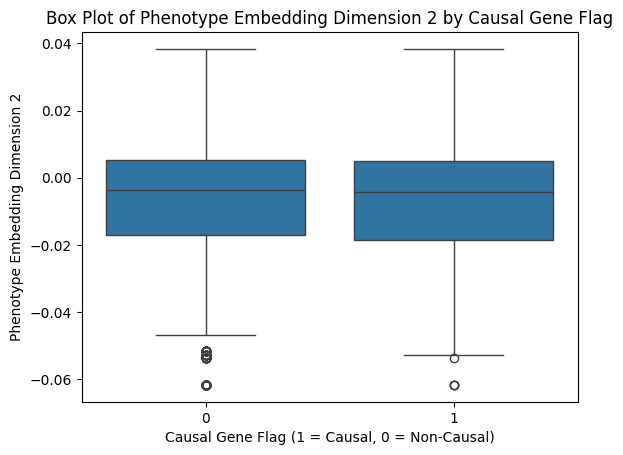

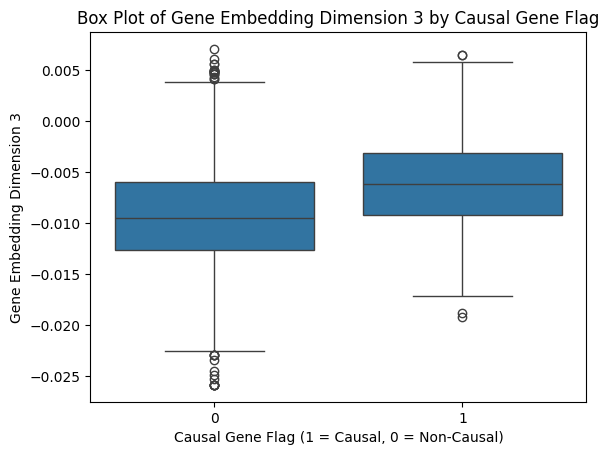

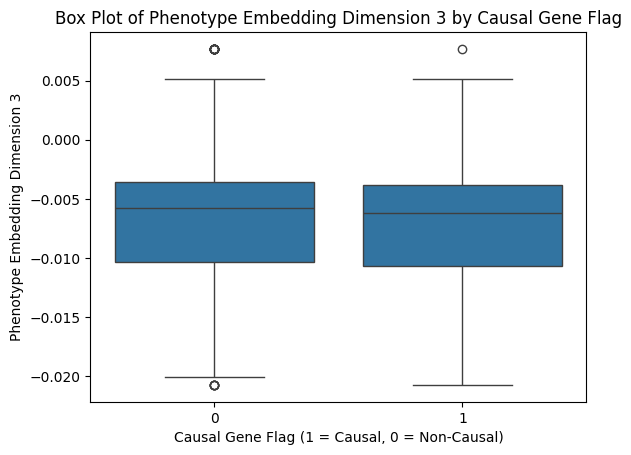

In [42]:
# Visualization 1: Box Plot of Gene and Phenotype Embeddings by Causal Flag
plt.figure(figsize=(12, 6))
for i in range(3):  # Visualizing just the first 3 dimensions to keep the plot readable
    sns.boxplot(x='causal_gene_flag', y=f'gene_emb_{i+1}', data=gene_embedding_df)
    plt.title(f'Box Plot of Gene Embedding Dimension {i+1} by Causal Gene Flag')
    plt.xlabel('Causal Gene Flag (1 = Causal, 0 = Non-Causal)')
    plt.ylabel(f'Gene Embedding Dimension {i+1}')
    plt.show()

    sns.boxplot(x='causal_gene_flag', y=f'phen_emb_{i+1}', data=phenotype_embedding_df)
    plt.title(f'Box Plot of Phenotype Embedding Dimension {i+1} by Causal Gene Flag')
    plt.xlabel('Causal Gene Flag (1 = Causal, 0 = Non-Causal)')
    plt.ylabel(f'Phenotype Embedding Dimension {i+1}')
    plt.show()

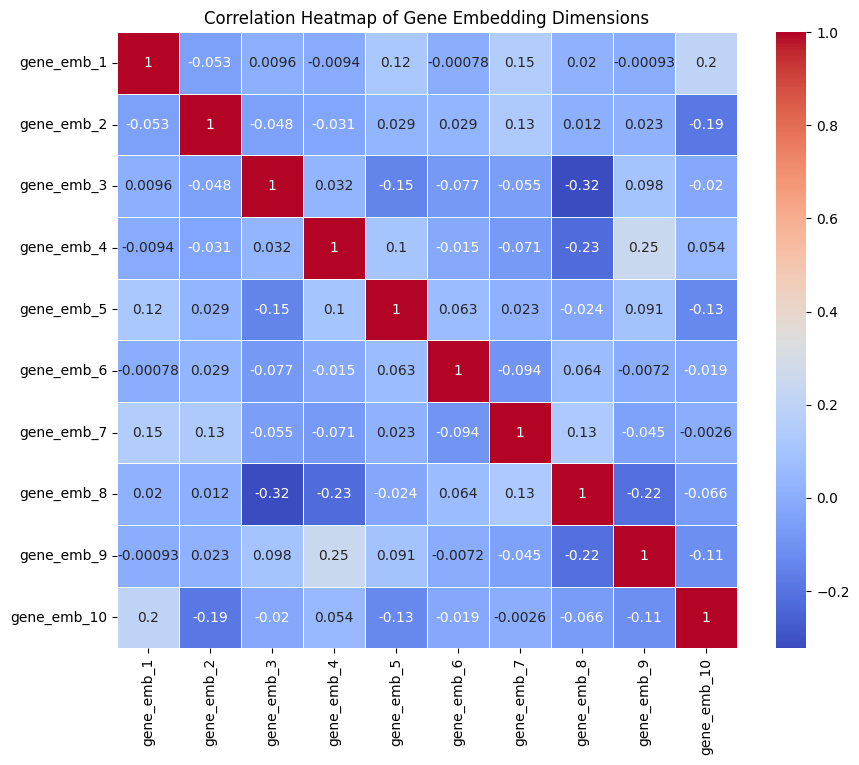

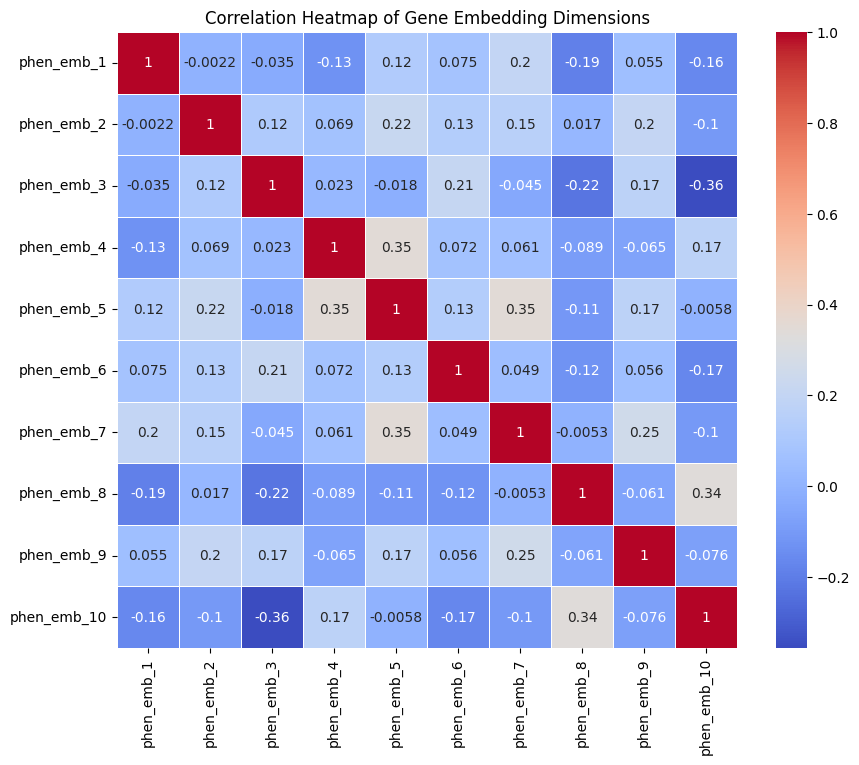

In [43]:
# Visualization 2: Correlation Heatmap for Gene and Phenotype Embedding Dimensions
plt.figure(figsize=(10, 8))
gene_corr_matrix = gene_embedding_df.iloc[:, :10].corr()
phen_corr_matrix = phenotype_embedding_df.iloc[:, :10].corr()  # Considering the first 10 dimensions
sns.heatmap(gene_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Gene Embedding Dimensions')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(phen_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Gene Embedding Dimensions')
plt.show()


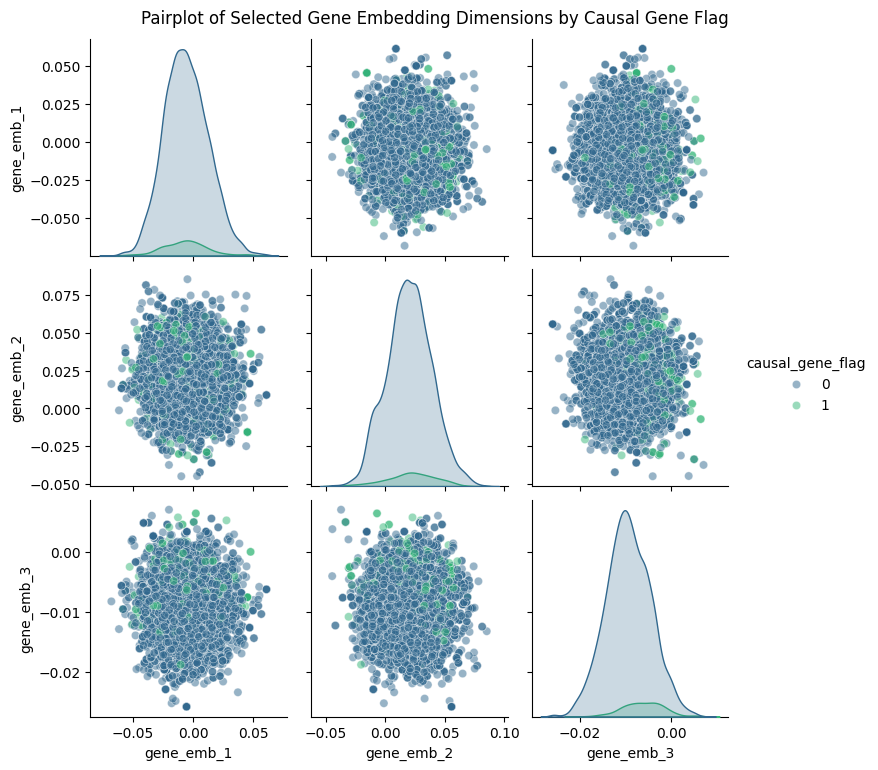

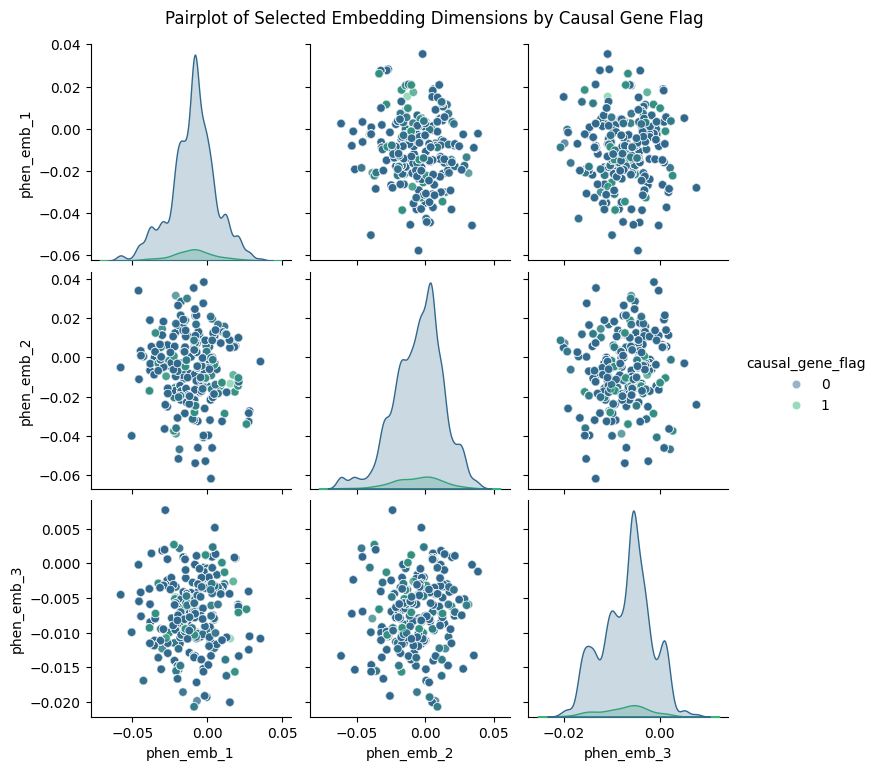

In [44]:
# Visualization 3: Pairplot of Gene and Phenotype Embedding Dimensions
sns.pairplot(gene_embedding_df, vars=[f'gene_emb_{i+1}' for i in range(3)], hue='causal_gene_flag', palette='viridis', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Selected Gene Embedding Dimensions by Causal Gene Flag', y=1.02)
plt.show()

sns.pairplot(phenotype_embedding_df, vars=[f'phen_emb_{i+1}' for i in range(3)], hue='causal_gene_flag', palette='viridis', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Selected Phenotype Embedding Dimensions by Causal Gene Flag', y=1.02)
plt.suptitle('Pairplot of Selected Embedding Dimensions by Causal Gene Flag', y=1.02)
plt.show()


### Box Plots of Gene and Phenotype Embeddings by Causal Flag

The box plots indicate that there is no significant visual separation between causal and non-causal groups for individual gene and phenotype embedding dimensions.
The distributions and central tendencies (median, quartiles) are quite similar for both causal and non-causal groups, suggesting limited variance between the two groups for these dimensions.

### Correlation Heatmap for Gene and Phenotype Embedding Dimensions

There is no clear indication of strong correlations between the embedding dimensions, as most correlations are near zero.
The lack of strong positive or negative correlations suggests that individual embedding dimensions are largely independent of one another.

### Pairplots of Selected Gene and Phenotype Embedding Dimensions by Causal Flag

The pairplots show a high degree of overlap between causal and non-causal categories across embedding dimensions, suggesting difficulty in linearly separating causal from non-causal genes using these individual dimensions.
Green markers for causal genes are dispersed within the blue non-causal genes, which indicates that embeddings might not clearly distinguish causal genes using simple linear relationships.

# Next - Dimensionality reduction using t-SNE

In [45]:
from sklearn.manifold import TSNE

In [46]:
# t-SNE for Dimensionality Reduction
# Apply t-SNE to gene embeddings to reduce dimensions to 2 for visualization
gene_tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
gene_reduced_tsne = gene_tsne.fit_transform(gene_embedding_values)

d:\Saravanesh Personal\Guvi\Guvi_Career_Fair\Gene_Causuality_Exploration\geneenv\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [47]:
# Apply t-SNE to phenotype embeddings to reduce dimensions to 2 for visualization
phen_tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
phen_reduced_tsne = phen_tsne.fit_transform(phenotype_embedding_values)

d:\Saravanesh Personal\Guvi\Guvi_Career_Fair\Gene_Causuality_Exploration\geneenv\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [48]:
# Add the reduced components to the dataframes for visualization
gene_embedding_df['TSNE1'] = gene_reduced_tsne[:, 0]
gene_embedding_df['TSNE2'] = gene_reduced_tsne[:, 1]
phenotype_embedding_df['TSNE1'] = phen_reduced_tsne[:, 0]
phenotype_embedding_df['TSNE2'] = phen_reduced_tsne[:, 1]

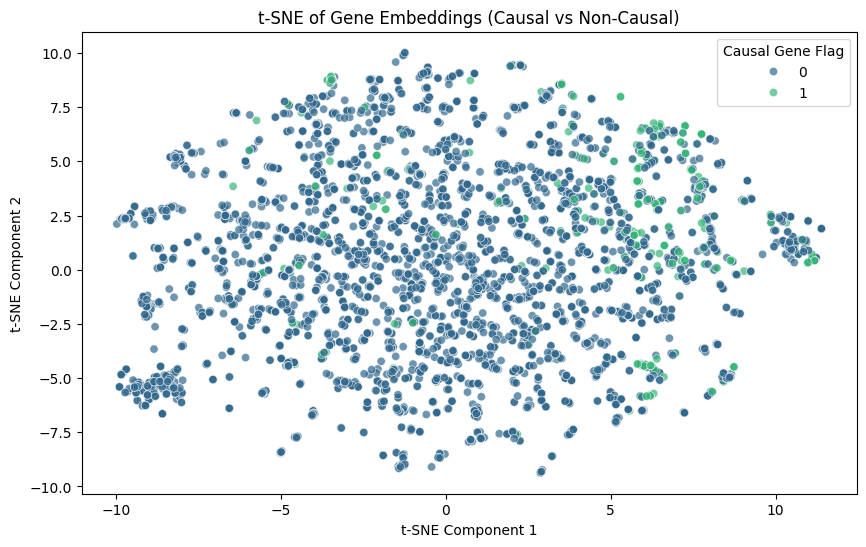

In [49]:
# Plotting the t-SNE components with hue based on causal_gene_flag
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='causal_gene_flag', data=gene_embedding_df, palette='viridis', alpha=0.7)
plt.title('t-SNE of Gene Embeddings (Causal vs Non-Causal)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Causal Gene Flag')
plt.show()


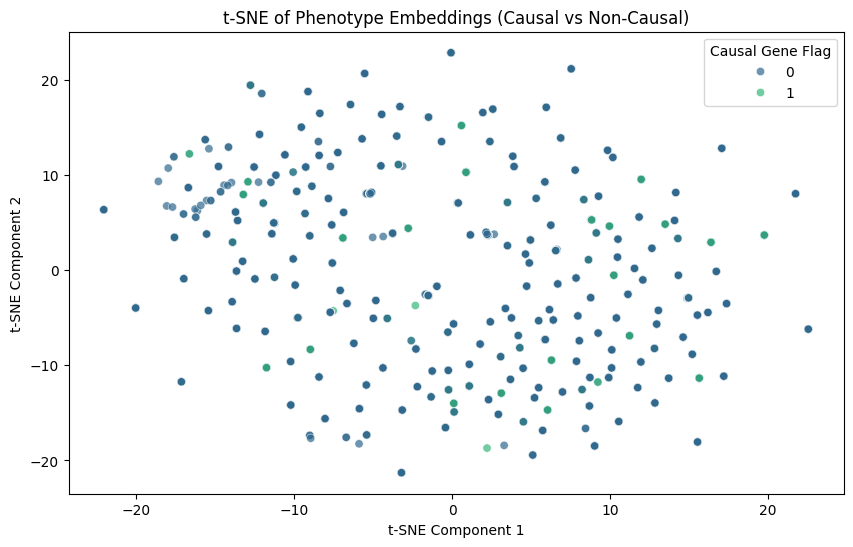

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='causal_gene_flag', data=phenotype_embedding_df, palette='viridis', alpha=0.7)
plt.title('t-SNE of Phenotype Embeddings (Causal vs Non-Causal)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Causal Gene Flag')
plt.show()


## Clustering using PCA

In [51]:
# PCA for Dimensionality Reduction
from sklearn.decomposition import PCA

In [52]:
# Apply PCA to gene embeddings to reduce dimensions to 2 for visualization
gene_pca = PCA(n_components=2)
gene_reduced = gene_pca.fit_transform(gene_embedding_values)

In [53]:
# Apply PCA to phenotype embeddings to reduce dimensions to 2 for visualization
phen_pca = PCA(n_components=2)
phen_reduced = phen_pca.fit_transform(phenotype_embedding_values)


In [54]:
# Add the reduced components to the dataframes for visualization
gene_embedding_df['PCA1'] = gene_reduced[:, 0]
gene_embedding_df['PCA2'] = gene_reduced[:, 1]
phenotype_embedding_df['PCA1'] = phen_reduced[:, 0]
phenotype_embedding_df['PCA2'] = phen_reduced[:, 1]


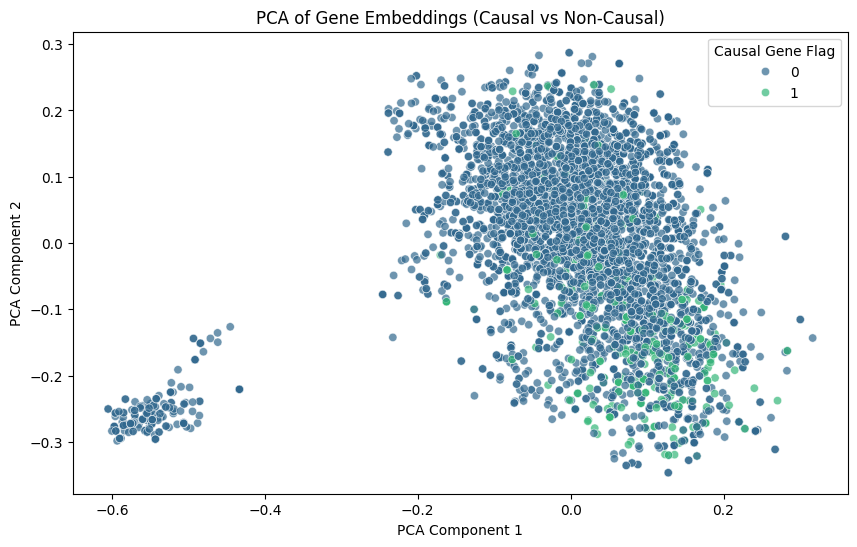

In [55]:
# Plotting the PCA components with hue based on causal_gene_flag
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='causal_gene_flag', data=gene_embedding_df, palette='viridis', alpha=0.7)
plt.title('PCA of Gene Embeddings (Causal vs Non-Causal)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Causal Gene Flag')
plt.show()

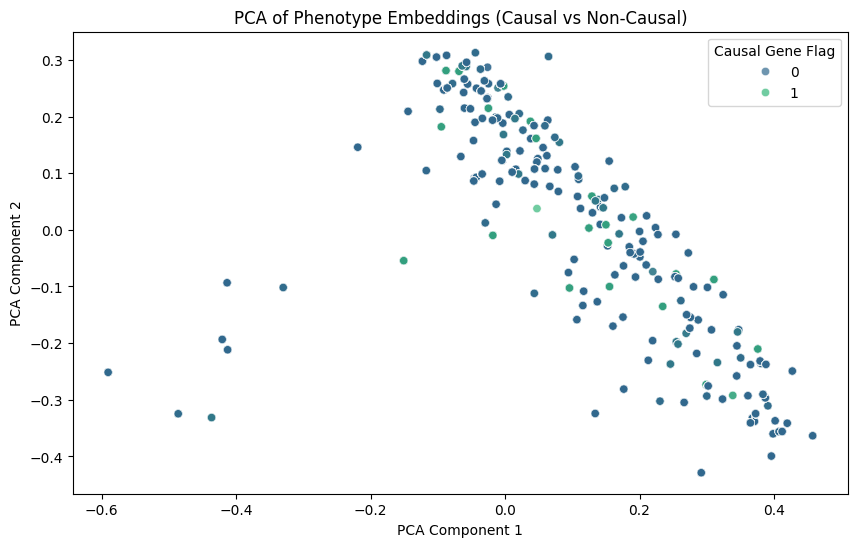

In [56]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='causal_gene_flag', data=phenotype_embedding_df, palette='viridis', alpha=0.7)
plt.title('PCA of Phenotype Embeddings (Causal vs Non-Causal)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Causal Gene Flag')
plt.show()


In [74]:
gene_embedding_df[['TSNE1','TSNE2','PCA1','PCA2','causal_gene_flag']]

,TSNE1,TSNE2,PCA1,PCA2,causal_gene_flag
0,-4.445529,5.756485,-0.117133,0.145262,0
1,-3.503401,8.615540,0.020436,0.024159,1
2,-8.713446,0.974301,-0.111376,0.176073,0
3,-4.092650,1.416488,-0.065882,0.136038,0
4,5.160072,-7.022799,0.176863,-0.149577,1
...,...,...,...,...,...
5461,1.203486,-4.396913,0.084747,0.106551,0
5462,-6.346253,7.239384,-0.051754,0.165015,0
5463,2.470803,-6.355668,-0.006390,-0.050364,0
5464,7.280387,-0.435874,-0.038687,-0.136918,0


In [75]:
phenotype_embedding_df[['TSNE1','TSNE2','PCA1','PCA2','causal_gene_flag']]

,TSNE1,TSNE2,PCA1,PCA2,causal_gene_flag
0,-0.664987,13.498930,-0.091239,0.246973,0
1,-0.664987,13.498930,-0.091239,0.246973,1
2,-0.667795,13.484988,-0.091239,0.246973,0
3,-0.664987,13.498930,-0.091239,0.246973,0
4,-13.216726,7.931103,-0.002124,0.253930,1
...,...,...,...,...,...
5461,-5.534532,20.639608,0.107793,0.058980,0
5462,-5.534532,20.639608,0.107793,0.058980,0
5463,-5.534532,20.639608,0.107793,0.058980,0
5464,-5.534532,20.639608,0.107793,0.058980,0


### t-SNE for Gene Embeddings:

The causal genes (1) are scattered, indicating no clear separation between causal and non-causal genes (0).
t-SNE provides a more spread-out visualization, but clusters of different labels are overlapping, suggesting that the embeddings might not capture strong differences.

### t-SNE for Phenotype Embeddings:

The plot shows a similar spread of points for both causal and non-causal genes, with significant overlap.
There are regions where some causal genes (1) cluster together, but overall there isn’t a clear separation from non-causal genes (0).

### PCA for Gene Embeddings:

The PCA plot for gene embeddings has a clear concentration of most points, with no evident separation between causal and non-causal genes.
There is a visible cluster at the far left, but the distinction based on causal status is minimal.

### PCA for Phenotype Embeddings:

The PCA plot of phenotype embeddings shows less overlap, with some clusters being loosely formed.
There is still considerable spread among causal (1) and non-causal (0) genes, without distinct grouping.

### Comparison t-SNE vs PCA:
t-SNE provides more granularity in the spread of points, suggesting that it is better at capturing subtle variations in the embeddings.
PCA, in comparison, shows a more compressed clustering, making it harder to differentiate causal from non-causal genes.
t-SNE’s higher spread may provide better differentiation for visualization purposes, though it doesn't necessarily translate to improved separation of causal relationships.

## Performing the DBscan Clustering

In [57]:
from sklearn.cluster import DBSCAN


In [76]:
# Combine phenotype and gene embeddings
combined_embeddings = np.hstack((phenotype_embedding_values, gene_embedding_values))

In [77]:
# Apply DBSCAN to combined embeddings without scaling
combined_dbscan = DBSCAN(eps=0.5, min_samples=5)
combined_clusters = combined_dbscan.fit_predict(combined_embeddings)


In [78]:
# Add the cluster labels to the dataframe
combined_embedding_df = pd.DataFrame(combined_embeddings, columns=[f'combined_emb_{i+1}' for i in range(combined_embeddings.shape[1])])
combined_embedding_df['dbscan_cluster'] = combined_clusters


In [80]:
combined_embedding_df['dbscan_cluster'].value_counts()

dbscan_cluster
-1     5282
 19      20
 13      20
 4       10
 11      10
 6        9
 5        9
 20       9
 7        9
 16       8
 3        8
 21       8
 17       8
 10       8
 15       8
 2        5
 1        5
 0        5
 8        5
 12       5
 9        5
 14       5
 18       5
Name: count, dtype: int64

In [79]:
combined_embedding_df.head(5)

,combined_emb_1,combined_emb_2,combined_emb_3,combined_emb_4,combined_emb_5,combined_emb_6,combined_emb_7,combined_emb_8,combined_emb_9,combined_emb_10,...,combined_emb_6136,combined_emb_6137,combined_emb_6138,combined_emb_6139,combined_emb_6140,combined_emb_6141,combined_emb_6142,combined_emb_6143,combined_emb_6144,dbscan_cluster
0,-0.002417,-0.006652,-0.002195,0.022206,0.017092,-0.024992,0.010741,-0.056691,0.039636,-0.028466,...,-0.007859,0.047153,-0.017782,-0.001990,-0.005954,0.015202,0.002514,0.012847,0.002532,-1
1,-0.002417,-0.006652,-0.002195,0.022206,0.017092,-0.024992,0.010741,-0.056691,0.039636,-0.028466,...,-0.008159,0.010711,-0.012765,0.020846,-0.019474,0.017049,-0.017580,-0.001343,-0.006111,-1
2,-0.002417,-0.006652,-0.002195,0.022206,0.017092,-0.024992,0.010741,-0.056691,0.039636,-0.028466,...,0.011050,0.040699,-0.025676,0.003734,-0.023762,0.023787,0.001272,-0.012208,-0.003803,-1
3,-0.002417,-0.006652,-0.002195,0.022206,0.017092,-0.024992,0.010741,-0.056691,0.039636,-0.028466,...,0.002154,0.032134,-0.025185,-0.013395,-0.016510,0.020380,-0.013898,-0.011963,0.007770,-1
4,-0.025578,-0.001691,-0.010040,-0.033463,0.005115,-0.018669,0.037875,-0.061863,0.045535,-0.008074,...,0.011172,0.010775,-0.008978,-0.018641,-0.000665,0.007374,-0.020576,-0.003702,-0.003489,-1


In [81]:
# Visualization: Scatter Plot of DBSCAN Clustering on Combined Embeddings using t-SNE
# Using t-SNE to reduce dimensions to 2 for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_tsne = tsne.fit_transform(combined_embeddings)


In [82]:
combined_embedding_df['TSNE1'] = combined_tsne[:, 0]
combined_embedding_df['TSNE2'] = combined_tsne[:, 1]


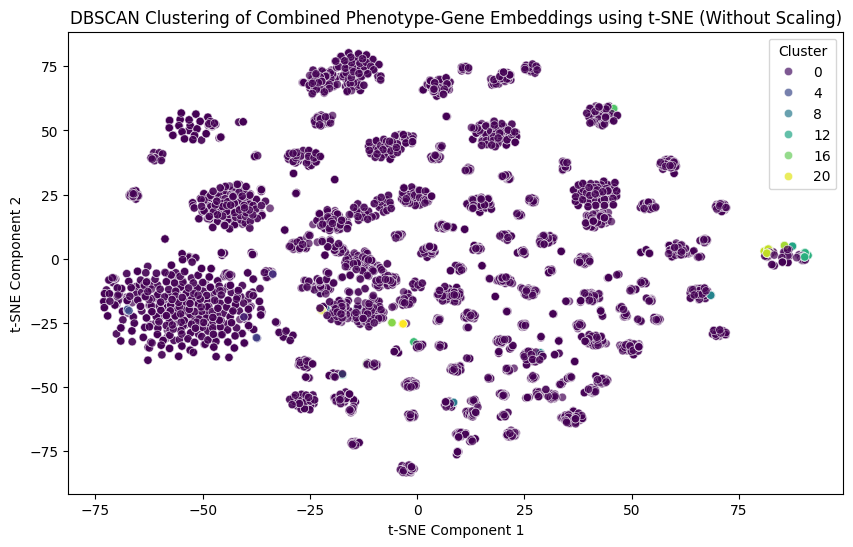

In [83]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='dbscan_cluster', data=combined_embedding_df, palette='viridis', alpha=0.7)
plt.title('DBSCAN Clustering of Combined Phenotype-Gene Embeddings using t-SNE (Without Scaling)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


## Apply Kmeans clustering

In [92]:
from sklearn.cluster import KMeans

In [93]:
# Apply KMeans to combined embeddings without scaling
kmeans = KMeans(n_clusters=5, random_state=42)
combined_clusters_kmeans = kmeans.fit_predict(combined_embeddings)


In [94]:
# Add the cluster labels to the dataframe
combined_embedding_df = pd.DataFrame(combined_embeddings, columns=[f'combined_emb_{i+1}' for i in range(combined_embeddings.shape[1])])
combined_embedding_df['kmeans_cluster'] = combined_clusters_kmeans


In [95]:
# Visualization: Scatter Plot of KMeans Clustering on Combined Embeddings using t-SNE
# Using t-SNE to reduce dimensions to 2 for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
combined_tsne = tsne.fit_transform(combined_embeddings)


In [96]:
combined_embedding_df['TSNE1'] = combined_tsne[:, 0]
combined_embedding_df['TSNE2'] = combined_tsne[:, 1]


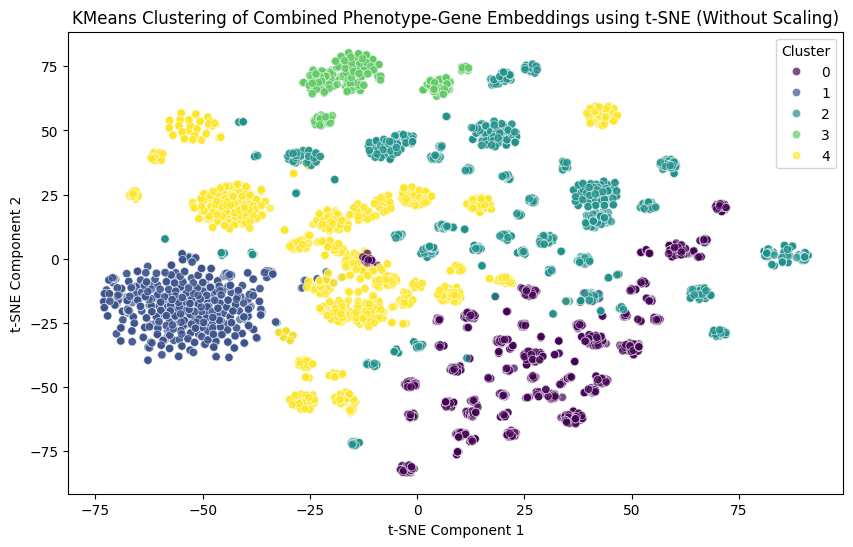

In [97]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='kmeans_cluster', data=combined_embedding_df, palette='viridis', alpha=0.7)
plt.title('KMeans Clustering of Combined Phenotype-Gene Embeddings using t-SNE (Without Scaling)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


KMeans vs DBSCAN Cluster Formation: 

The KMeans clusters are more distinct and evenly spread across the t-SNE space, which suggests that KMeans is able to identify well-separated clusters from the combined phenotype-gene embeddings. DBSCAN, on the other hand, forms a large majority of points into a single cluster (label 0) and many smaller clusters, suggesting that the data has significant density variations, and DBSCAN identifies areas of higher density as separate clusters.

Outlier Detection by DBSCAN: 

The DBSCAN clustering plot also shows that it labels a number of points with unique cluster labels (e.g., 4, 8, 12, etc.), which might represent outliers or smaller dense groups within the dataset. This shows DBSCAN's effectiveness at identifying noise or anomalies that may not fit into larger clusters, unlike KMeans, which forces all points into predefined clusters.

Cluster Interpretation: 

KMeans appears to provide a clearer segmentation, potentially making it easier to interpret clusters as groups of phenotype-gene combinations. In contrast, DBSCAN captures subtle groupings and noise points, making it suitable if we want to focus on regions of varying density or remove outliers.